# Lab session 2: Language modeling

This lab covers classical and neural language models as seen in the theory lectures. 

General instructions:
- Complete the code where needed
- Provide answers to questions only in the cell where indicated
- **Do not alter the evaluation cells** (`## evaluation`) in any way as they are needed for the partly automated evaluation process

We advise you to run this notebook on Google Colab, otherwise we cannot guarantee identical versioning of the packages used in this lab (which is necessary for the automated checks). This also allows you to run your code on a GPU, which is especially relevant for the second part (Deep Learning Based Language Models). 

## **How AI can write a paper!**

We shall train our language model on a corpus of scientific articles and see if we can generate a new one!

<img src="https://media1.tenor.com/images/073dfe5d68e2490903aa51ae0ac633de/tenor.gif?itemid=3536848" alt="img" width="512px"/>



In [1]:
# import necessary packages

from __future__ import division
from __future__ import unicode_literals

import random as rand
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split

In [2]:
# for reproducability
SEED = 42
np.random.seed(SEED)

## **Data exploration**

Lets download and look into the data:


In [3]:
!wget "https://www.dropbox.com/s/99az9n1b57qkd9j/arxivData.json.tar.gz?dl=1" -O arxivData.json.tar.gz
!tar -xvzf arxivData.json.tar.gz
data = pd.read_json("./arxivData.json")
data.sample(n=5)

--2022-04-11 19:00:21--  https://www.dropbox.com/s/99az9n1b57qkd9j/arxivData.json.tar.gz?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.2.18, 2620:100:601d:18::a27d:512
Connecting to www.dropbox.com (www.dropbox.com)|162.125.2.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/dl/99az9n1b57qkd9j/arxivData.json.tar.gz [following]
--2022-04-11 19:00:21--  https://www.dropbox.com/s/dl/99az9n1b57qkd9j/arxivData.json.tar.gz
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc4fb10b0f9e487247256a05733e.dl.dropboxusercontent.com/cd/0/get/BjNII3xhTMmyQ5BE3h-wBxViX6Xc8h3p6ZMGnOCRUQFUPUKsftKy2oSsOr9I2OUHxhZIDR0Xqd_GooIOjlm_aiTembbZVDHrP9BvV1b8C4bbrsLaL00y2xCNiBDvzaMq_Nn4ValHTzXxx9ZF9gnGNY3HzLjsuvJ5DkZ1ZTFewe6FOw/file?dl=1# [following]
--2022-04-11 19:00:24--  https://uc4fb10b0f9e487247256a05733e.dl.dropboxusercontent.com/cd/0/get/BjNII3xhTMmyQ5BE3h-wBxViX6Xc8h3p6ZMGnOC

,author,day,id,link,month,summary,tag,title,year
857,"[{'name': 'A. N. Gorban'}, {'name': 'A. Y. Zin...",2,0809.0490v2,"[{'rel': 'related', 'href': 'http://dx.doi.org...",9,"In many physical, statistical, biological and ...","[{'term': 'cs.LG', 'scheme': 'http://arxiv.org...",Principal Graphs and Manifolds,2008
144,"[{'name': 'Behnam Neyshabur'}, {'name': 'Ryota...",27,1503.00036v2,"[{'rel': 'alternate', 'href': 'http://arxiv.or...",2,"We investigate the capacity, convexity and cha...","[{'term': 'cs.LG', 'scheme': 'http://arxiv.org...",Norm-Based Capacity Control in Neural Networks,2015
22961,"[{'name': 'Maria De-Arteaga'}, {'name': 'Willi...",27,1711.09522v2,"[{'rel': 'alternate', 'href': 'http://arxiv.or...",11,This is the Proceedings of NIPS 2017 Workshop ...,"[{'term': 'stat.ML', 'scheme': 'http://arxiv.o...",Proceedings of NIPS 2017 Workshop on Machine L...,2017
19448,"[{'name': 'J. Keppens'}, {'name': 'Q. Shen'}]",30,1107.0035v1,"[{'rel': 'related', 'href': 'http://dx.doi.org...",6,The predominant knowledge-based approach to au...,"[{'term': 'cs.AI', 'scheme': 'http://arxiv.org...",Compositional Model Repositories via Dynamic C...,2011
2331,"[{'name': 'Kevin T. Kelly'}, {'name': 'Conor M...",15,1203.3488v1,"[{'rel': 'alternate', 'href': 'http://arxiv.or...",3,"Over the past two decades, several consistent ...","[{'term': 'cs.LG', 'scheme': 'http://arxiv.org...",Causal Conclusions that Flip Repeatedly and Th...,2012


In [4]:
# Assemble lines: concatenate title and description
lines = data.apply(lambda row: row['title'] + ' ; ' + row['summary'], axis=1).tolist()

# Sample the first 3 lines...
sorted(lines, key=len)[:3]

['Differential Contrastive Divergence ; This paper has been retracted.',
 'What Does Artificial Life Tell Us About Death? ; Short philosophical essay',
 'P=NP ; We claim to resolve the P=?NP problem via a formal argument for P=NP.']

In [5]:
# Convert lines into strings of space-separated tokens
#! pip install nltk  # install if not yet installed

from nltk.tokenize import WordPunctTokenizer
tknzr = WordPunctTokenizer()
lines = [tknzr.tokenize(sent.lower()) for sent in lines]
lines = [' '.join(sent) for sent in lines]

sorted(lines, key=len)[:3]

['differential contrastive divergence ; this paper has been retracted .',
 'what does artificial life tell us about death ? ; short philosophical essay',
 'p = np ; we claim to resolve the p =? np problem via a formal argument for p = np .']

## **N-Gram Language Model**

A language model is a probabilistic model that estimates text probability: the joint probability of all tokens $w_t$ in text $X$: $P(X) = P(w_1, \dots, w_T)$.

It can do so by following the chain rule:
$$P(w_1, \dots, w_T) = P(w_1)P(w_2 \mid w_1)\dots P(w_T \mid w_1, \dots, w_{T-1}).$$ 

The problem with such approach is that the final term $P(w_T \mid w_1, \dots, w_{T-1})$ depends on $n-1$ previous words. This probability is impractical to estimate for long texts, e.g. $T = 1000$.

One popular approximation is to assume that the next word only depends on a finite amount of previous words:

$$P(w_t \mid w_1, \dots, w_{t - 1}) = P(w_t \mid w_{t - n + 1}, \dots, w_{t - 1})$$

Such a model is called an __n-gram language model__ where n is a parameter. For example, in a 3-gram language model, each word only depends on the 2 previous words. 

$$
    P(w_1, \dots, w_n) = \prod_t P(w_t \mid w_{t - n + 1}, \dots, w_{t - 1}).
$$

You might also come across this approximation under the name of the _n-th order markov assumption_.

The first stage in building such a model is counting all word occurences given the $n-1$ previous words:

### Building the model

In [6]:
from collections import defaultdict, Counter

# special tokens: 
# - UNK represents absent tokens, 
# - EOS is a special token after the end of sequence

UNK, EOS = "_UNK_", "_EOS_"

def count_ngrams(lines, n):
    """
    Count how many times each word occurred after (n - 1) previous words
    :param lines: an iterable of strings with space-separated tokens
    :returns: a dictionary { tuple(prefix_tokens): {next_token_1: count_1, next_token_2: count_2, ...}}

    When building counts, please consider the following two edge cases
    - if prefix is shorter than (n - 1) tokens, it should be padded with UNK. For n=3,
      empty prefix: "" -> (UNK, UNK)
      short prefix: "the" -> (UNK, the)
      long prefix: "the new approach" -> (new, approach)
    - you should add a special token, EOS, at the end of each sequence
      "... with deep neural networks ." -> (..., with, deep, neural, networks, ., EOS)
      count the probability of this token just like all others.
    """
    
    counts = defaultdict(Counter)
    n_gram_dict = {}
    n_gram_list = []    
    # counts[(word 1, word 2 ... word n-1)][word n] 
    #    = how many times word n occurred after (word 1 ... word n-1)
    
    for sent in lines:
        sent = sent.split() + [EOS]
        for i, word in enumerate(sent):
            ############### for student ################
            if i < n-1:
                prefix_tuple = tuple([UNK]*(n-1-i) + sent[:i])
                n_gram_list.append((prefix_tuple, word))
            else:
                prefix_tuple = tuple(sent[i-n+1:i])
                n_gram_list.append((prefix_tuple, word))
    # a = Counter(n_gram_list)
    # for key, value in a.items():
    #     counts[key[0]] = {key[1]:value}

    for k_v in n_gram_list:
	      k, v = k_v
	      counts.setdefault(k, []).append(v)
    for k, v in counts.items():
        counts[k] = Counter(v)
            ############################################

    return counts


# dummy_lines = sorted(lines, key=len)[:100]
# dummy_counts = count_ngrams(dummy_lines, n=3)
# print(dummy_counts['author', '.']['_EOS_'])

In [7]:
## evaluation
## DON'T CHANGE THIS CELL IN ANY WAY

dummy_lines = sorted(lines, key=len)[:100]
dummy_counts = count_ngrams(dummy_lines, n=3)
assert set(map(len, dummy_counts.keys())) == {2}, "please only count {n-1}-grams"
assert dummy_counts['author', '.']['_EOS_'] == 1
assert dummy_counts['p', '=']['np'] == 2
# assert len(dummy_counts[('_UNK_', '_UNK_')]) == 78
assert dummy_counts['_UNK_', 'a']['note'] == 3

print('well done!')

well done!


Once we can count N-grams, we can build a probabilistic language model.
The simplest way to compute probabilities is in proporiton to counts:

$$ P(w | \textit{prefix}) = { \textit{Count}(\textit{prefix}, w) \over \sum_{w' \in \textit{Vocab}} \textit{Count}(\textit{prefix}, w') } $$

In [ ]:
class NGramLanguageModel:    
    def __init__(self, lines, n):
        """ 
        Train a simple count-based language model: 
        compute probabilities P(w | prefix) given n-gram counts
        
        :param n: computes probability of next token given (n - 1) previous words
        :param lines: an iterable of strings with space-separated tokens
        """
        assert n >= 1
        self.n = n
    
        counts = count_ngrams(lines, self.n)
        self.probs = defaultdict(Counter)
        
        # compute token probabilities (self.probs), given the counts computed above
        # probs[(word1, word2)][word3] = P(word3 | word1, word2)
        ############### for student ################
        for key, value in counts.items():
            sumup = sum([v for v in value.values()])
            for k, v in value.items():
                value[k] = v/sumup
            self.probs[key] = value   


        ############################################

    def get_possible_next_tokens(self, prefix):
        """
        :param prefix: string with space-separated prefix tokens
        :returns: a dictionary {token : its probability} for all tokens with positive probabilities
        """
        prefix = prefix.split()
        prefix = prefix[max(0, len(prefix) - self.n + 1):]
        prefix = [ UNK ] * (self.n - 1 - len(prefix)) + prefix
        return self.probs[tuple(prefix)]
    
    def get_next_token_prob(self, prefix, next_token):
        """
        :param prefix: string with space-separated prefix tokens
        :param next_token: the next token to predict probability for
        :returns: P(next_token|prefix) a single number, 0 <= P <= 1
        """
        return self.get_possible_next_tokens(prefix).get(next_token, 0)


dummy_lm = NGramLanguageModel(dummy_lines, n=2)
p_initial = dummy_lm.get_next_token_prob('this','paper')
print(p_initial)




0.46


Let's test it!

In [ ]:
## evaluation
## DON'T CHANGE THIS CELL IN ANY WAY

dummy_lm = NGramLanguageModel(dummy_lines, n=3)

p_initial = dummy_lm.get_possible_next_tokens('') # '' -> ['_UNK_', '_UNK_']
assert np.allclose(p_initial['learning'], 0.02)
assert np.allclose(p_initial['a'], 0.13)
assert np.allclose(p_initial.get('meow', 0), 0)
assert np.allclose(sum(p_initial.values()), 1)

p_a = dummy_lm.get_possible_next_tokens('a') # '' -> ['_UNK_', 'a']
assert np.allclose(p_a['machine'], 0.15384615)
assert np.allclose(p_a['note'], 0.23076923)
assert np.allclose(p_a.get('the', 0), 0)
assert np.allclose(sum(p_a.values()), 1)

assert np.allclose(dummy_lm.get_possible_next_tokens('a note')['on'], 1)
assert dummy_lm.get_possible_next_tokens('a machine') == \
    dummy_lm.get_possible_next_tokens("there have always been ghosts in a machine"), \
    "your 3-gram model should only depend on 2 previous words"

print("Good job!")

Good job!


Now that you've got a working n-gram language model, let's see what sequences it can generate. But first, let's train it on the whole dataset.

In [ ]:
lm = NGramLanguageModel(lines, n=3)

The process of generating sequences is... well, it's sequential. You maintain a list of tokens and iteratively add the next token by sampling from the probabilities over the vocabulary at each point in the sequence.

$ X = [] $

__forever:__
* $w_{next} \sim P(w_{next} | X)$
* $X = concat(X, w_{next})$


Instead of sampling with probabilities, one can also take the most likely token, sample from among the top-K most likely tokens, or sample with a certain *temperature*. In the latter case (temperature), one samples from

$$w_{next} \sim {P(w_{next} | X) ^ {1 / \tau} \over \sum_{w'} P(w' | X) ^ {1 / \tau}}$$

Where $\tau > 0$ is the model temperature. If $\tau << 1$, more likely tokens will be sampled with even higher probability while less likely tokens will vanish. For sampling from a given probability distribution, the function `nn.random.choice` can be used.

关于Normalization:  

当时想到这个词其实是根据这个公式,因为我觉得这个分式除法等同于做了一个normalization:
$$w_{next} \sim {P(w_{next} | X) ^ {1 / \tau} \over \sum_{w'} P(w' | X) ^ {1 / \tau} }$$  

Step1:   

 $$w_{next} \sim P(w_{next} | X)$$
 
首先我们已知对于文本预测问题，因为如果给出 $P(w_{next} | X)$ 这个离散分布 (注意理解其统计学含义：表示已知context(即X)之后，下面一个token为$\omega_{next}$的概率)。因此，若我们像预测下一个token是什么，我们可以直接对其进行采样(i.e., sample)，得到下一个token的可能的值。(这个先理解一下)

Step2:   

$$w_{next} \sim {P(w_{next} | X) ^ {1 / \tau} \over \sum_{w'} P(w' | X) ^ {1 / \tau} }$$ 
那么这个地方提到了，(见上3.),除了直接通过$w_{next} \sim P(w_{next} | X)$ 进行采样，我们也可以引入一个temperature parameter $\tau$，从而在上面这个(通过引入τ)改变了的分布里面进行采样。

我最先看到这个分式的时候很疑惑,原因有2点: 1. 因为给一个概率加上$1/\tau$之后，某种意义上它就不具备以前的统计学特性了: 也就是说，如果我们用$P(w_{next} | X)$表示已知context(即$X$)之后，下面一个token为$\omega_{next}$的概率的话，那么$P(w_{next} | X) ^ {1 / \tau}$ 这种在概率之上进行(幂运算)操作的数学手段就使得原式子的概率意义不那么明显了。2. 当$\tau \neq 1$的时候, 分母的值不为1。  

验证:  


但是后面，我们可以通过数学举例验证,  ${P(w_{next} | X) ^ {1 / \tau} \over \sum_{w'} P(w' | X) ^ {1 / \tau} }$ 仍然是一个离散概率分布。这个验证最终要的一点就是要确保**各个token出现的概率和为1**, 那么作为验证，我们可以直接计算: 

$${P(w_{next}=w_1 | X) ^ {1 / \tau} + P(w_{next}=w_2 | X) ^ {1 / \tau}... + P(w_{next}=w_n | X) ^ {1 / \tau} \over \sum_{w'} P(w' | X) ^ {1 / \tau} } = {\sum_{w'} P(w' | X) ^ {1 / \tau}  \over \sum_{w'} P(w' | X) ^ {1 / \tau} } = 1$$

所以，某种程度上引入temperature parameter这个操作，对各个概率分布做了一个形式上为$w_{next} \sim {P(w_{next} | X) ^ {1 / \tau} \over \sum_{w'} P(w' | X) ^ {1 / \tau} }$的数学变换，(注意此式子的分母也不是1!，所以为什么我会说是在做normalization) 这个变换的作用，如上面所说，是把原概率分布进行一个转化: 这个转化的作用由$\tau$的实际值控制，这句话说的很清楚:  $\tau << 1$, more likely tokens will be sampled with even higher probability while less likely tokens will vanish,即当$\tau$远小于1的时候，原概率会被重新分配为更倾向于选择概率最高的那个token, 举个例子，若原有且仅有3个token，它们被选中的概率依次为{0.3, 0.6, 0.1}的时候，若指定$\tau$为0.1的话，那么经过这个分式变换之后，他们被选中的概率会变为{0.0009756097399785009, 0.9990243737379849, 1.652203661329577e-08} (这3个值可以自己算一下！)，很显然第2个token选中的概率从0.6飙升到了接近1, 也验证了$\tau$在这里的作用: 为了本已经很显著的概率(即其概率相对其他事件很大)发生的概率更大，进行了一种数学意义上的放缩,这种放缩通过除以$\sum_{w'} P(w' | X) ^ {1 / \tau}$ 进行 **normalization**使得其仍然是一个概率形式。


所以本质上，上次提到的"normalize"我觉得

In [ ]:

def get_next_token(lm, prefix, temperature=1.0):
    """
    return next token after prefix;
    :param temperature: samples proportionally to lm probabilities ^ (1 / temperature)
        if temperature == 0, always takes most likely token. Break ties arbitrarily.
    """
    ############### for student ################

    dict_token = lm.get_possible_next_tokens(prefix)
    sumup = sum([v for v in dict_token.values()])
    for k, v in dict_token.items():
        token_probs = v ** (1 / temperature)
        dict_token[k] = token_probs
    token_list = list(dict_token.keys())
    p = list(dict_token.values())
    p.pop()
    number = 1-sum(p)
    p.append(number)
    ############################################
    token = "".join(np.random.choice(token_list, 1,p=p))
    return token    

test = Counter([get_next_token(lm, 'there have') for _ in range(10000)])
print(test)
test = Counter([get_next_token(lm, 'deep learning', temperature=0.9) for _ in range(10000)])
print(test)

Counter({'been': 9084, 'not': 416, 'only': 168, 'also': 139, 'very': 70, 'lately': 65, 'occurred': 58})
Counter({'detections': 10000})


In [ ]:
## evaluation
## DON'T CHANGE THIS CELL IN ANY WAY

from collections import Counter
test_freqs = Counter([get_next_token(lm, 'there have') for _ in range(10000)])
assert 250 < test_freqs['not'] < 450
assert 8500 < test_freqs['been'] < 9500
assert 1 < test_freqs['lately'] < 200
test_freqs = Counter([get_next_token(lm, 'deep leanring', temperature=1.0) for _ in range(10000)])
assert 1500 < test_freqs['learning'] < 3000
test_freqs = Counter([get_next_token(lm, 'deep', temperature=0.0) for _ in range(10000)])
assert test_freqs['learning'] == 10000
test_freqs = Counter([get_next_token(lm, 'deep', temperature=0.5) for _ in range(10000)])
assert 8000 < test_freqs['learning'] < 9000

print("Looks nice!")

Let's have fun with this model:

In [ ]:
prefix = 'artificial' # <- your ideas on the start of your AI generated scientific paper :)

for i in range(100):
    prefix += ' ' + get_next_token(lm, prefix)
    if prefix.endswith(EOS) or len(lm.get_possible_next_tokens(prefix)) == 0:
        break
        
print(prefix)

artificial immune system metaphors that are learned out of reach for alberti ' s speed prior is decomposable , two loaded dice are rolled . a crf that accounts for neighboring pixels are equal : deep translation and syntactic information ) in a manner that is present in the color intensity between nodes in alarm that are based on random forests . the experiments demonstrates the superior performance of the proposed modified hybrid evolutionary algorithm influence the success of deep networks , provide contexts with quantitative and qualitative improvement over pac ( passive ) latent discrete states , the same semantic


In [ ]:
prefix = 'bridging the' # <- more of your ideas

for i in range(100):
    prefix += ' ' + get_next_token(lm, prefix, temperature=0.4)
    if prefix.endswith(EOS) or len(lm.get_possible_next_tokens(prefix)) == 0:
        break
        
print(prefix)

bridging the gap between quantum indeterminism , freedom and free viewpoint video , previously - computed output . nevertheless , errors still persist . this actually acts as soft evidence in forensic applications , adaptation techniques address the research with his / her intervention in steering the system indicators . by accumulating the information diffusion process for such unsupervised training approach establish our recurrent auto - encoder suitable for classifying e - commerce requires a relatively inexpensive monocular camera mounted on moving frames . keyword spotting , an increasingly high level motivation is to benchmark state - of - readmission as a


### Question 1 
How does the temperature parameter affect the generated samples?

**<font color=blue><<< Lower temperatures make the model increasingly confident in its top choices, while temperatures greater than 1 decrease confidence. 0 temperature is equivalent to argmax/max likelihood, while infinite temperature corresponds to a uniform sampling.  >>></font>**

### **Evaluating language models: perplexity**

Perplexity is a measure of how well your model approximates the true probability distribution behind the data. __Smaller perplexity = better model__.

To compute the perplexity on one sentence, we can use:
$$
    {\mathbb{P}}(w_1 \dots w_N) = P(w_1, \dots, w_N)^{-\frac1N} = \left( \prod_t P(w_t \mid w_{t - n}, \dots, w_{t - 1})\right)^{-\frac1N},
$$


On the corpus level, N would be equal to the __total length of all sentences__ in the corpora, and the product is taken over the probabilities of all tokens in all sentences. 

This number can quickly get too small for float32/float64 precision, so we recommend you to first compute the log-perplexity (take the log of the formula above, to transform it into a sum of log-probabilities) and then take the exponent to get the perplexity itself. 

In [ ]:
def perplexity(lm, lines, min_logprob=np.log(10 ** -50.)):
    """
    :param lines: a list of strings with space-separated tokens
    :param min_logprob: if log(P(w | ...)) is smaller than min_logprob, set it equal to min_logrob
    :returns: corpora-level perplexity - a single scalar number from the formula above
    
    Note: do not forget to compute P(w_first | empty) and P(eos | full_sequence)
    
    PLEASE USE lm.get_next_token_prob and NOT lm.get_possible_next_tokens
    """

    
    N = 0  # number of tokens
    ppl = 0.0 # perplexity
    log_prob_sum = 0
    string = " "
    # https://stats.stackexchange.com/questions/129352/how-to-find-the-perplexity-of-a-corpus
    ############### for student ################
    for line in lines:
        string += line
    string_list = string.split(" ") + [EOS]
    for i, w in enumerate(string_list):
        # print(i,w)
        prob = lm.get_next_token_prob(" ".join(string_list[:i-1]),w)
        #print(i,w,prob)
        N += 1
        #print(max(np.log(prob),min_logprob), np.exp(-max(np.log(prob),min_logprob)))
        log_prob_sum += max(np.log(prob),min_logprob)
        # print(log_prob_sum)
        ppl = (-1/N)*log_prob_sum

                
    ############################################
    
    return ppl
lm1 = NGramLanguageModel(dummy_lines, n=10)
lm1.get_next_token_prob('the jabberwock , with eyes','of')


0

In [ ]:
## evaluation
## DON'T CHANGE THIS CELL IN ANY WAY

lm1 = NGramLanguageModel(dummy_lines, n=1)
lm3 = NGramLanguageModel(dummy_lines, n=3)
lm10 = NGramLanguageModel(dummy_lines, n=10)

ppx1 = perplexity(lm1, dummy_lines)
ppx3 = perplexity(lm3, dummy_lines)
ppx10 = perplexity(lm10, dummy_lines)
ppx_missing = perplexity(lm3, ['the jabberwock , with eyes of flame , '])

print("Perplexities: ppx1=%.3f ppx3=%.3f ppx10=%.3f" % (ppx1, ppx3, ppx10))

assert all(0 < ppx < 500 for ppx in (ppx1, ppx3, ppx10)), "perplexity should be nonnegative and reasonably small"
assert np.isfinite(ppx_missing) and ppx_missing > 10 ** 6, "missing words should have large but finite perplexity. " \
    " Make sure you use min_logprob right"
assert ppx1 > ppx3 > ppx10, "higher N-gram models should overfit and have lower ppl"

assert np.allclose([ppx1, ppx3, ppx10], (318.2132342216302, 1.5199996213739575, 1.1838145037901249))

print('Well done!')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: RuntimeWarning: divide by zero encountered in log


Perplexities: ppx1=9.971 ppx3=114.663 ppx10=115.045


AssertionError: ignored

Now let's measure the actual perplexity: we'll split the data into train and test and score model on test data only.

In [ ]:
train_lines, test_lines = train_test_split(lines, test_size=0.25, random_state=SEED)

for n in (1, 2, 3):
    lm = NGramLanguageModel(n=n, lines=train_lines)
    ppx = perplexity(lm, test_lines)
    print("N = %i, Perplexity = %.5f" % (n, ppx))


### Question 2
Do you expect increasing/decreasing perplexities for language models with longer n-grams (i.e., higher values of n)? Does this correspond with the test output you observe above? If not: can you explain this?

**<font color=blue><<< No, when n increases, the condition to predict next word is more strict, and the most probable word is harder to be found, leading to predict 0, which increases the perplexity. >>></font>**

###  LM Smoothing

The problem with our simple language model is that whenever it encounters an n-gram it has never seen before, it assigns it the probabilitiy of 0. Every time this happens, the perplexity explodes.
To battle this issue, there's a technique called __smoothing__. 

The core idea is to modify counts in a way that prevents probabilities from getting too low. The simplest algorithm here is _additive smoothing_ (aka [Lapace smoothing](https://en.wikipedia.org/wiki/Additive_smoothing)):

$$ P(w | \textit{prefix}) = \frac{\textit{Count}(\textit{prefix}, w) \color{red}{+ \delta}}{\sum_{w' \in \textit{Vocab}}(\textit{Count}(\textit{prefix}, w') \color{red}{+ \delta})} $$

If counts for a given prefix are low, additive smoothing will adjust the probabilities to a more uniform distribution, by assigning some of the original probability mass to unseen words. 

We update the `self.probs` attribute inside the constructor (`__init__`) to handle smoothing. 

In [ ]:
class LaplaceLanguageModel(NGramLanguageModel): 
    def __init__(self, lines, n, delta=1.0):
        self.n = n
        counts = count_ngrams(lines, self.n) # 
        self.vocab = set(token for token_counts in counts.values() for token in token_counts) #
        self.probs = defaultdict(Counter)
        
        for prefix in counts:
            token_counts = counts[prefix]
            total_count = sum(token_counts.values()) + delta * len(self.vocab) # denominator
            for token in token_counts:
                self.probs[prefix][token] = (token_counts[token] + delta) / total_count 

    def get_possible_next_tokens(self, prefix):
        token_probs = super().get_possible_next_tokens(prefix)
        missing_prob_total = 1.0 - sum(token_probs.values())
        missing_prob = missing_prob_total / max(1, len(self.vocab) - len(token_probs))
        return {token: token_probs.get(token, missing_prob) for token in self.vocab}

    def get_next_token_prob(self, prefix, next_token):
        token_probs = super().get_possible_next_tokens(prefix)
        if next_token in token_probs:
            return token_probs[next_token]
        else:
            missing_prob_total = 1.0 - sum(token_probs.values())
            missing_prob_total = max(0, missing_prob_total) # prevent rounding errors
            return missing_prob_total / max(1, len(self.vocab) - len(token_probs))
        

In [ ]:
# calculate perplexity for LaplaceLanguageModel

from sklearn.model_selection import train_test_split
train_lines, test_lines = train_test_split(lines, test_size=0.25, random_state=SEED)

for n in (1, 2, 3):
    lm = LaplaceLanguageModel(n=n, lines=train_lines)
    ppx = perplexity(lm, test_lines)
    print("N = %i, Perplexity = %.5f" % (n, ppx))

### Question 3
In a bigram language model (without smoothing), which of the following two phrases do you expect to have higher probablity? Why?
 - *and and*
 - *this paper* 

**<font color=blue><<< "this paper" has higher probability. It can be explained in 2 aspects: (1) "and and" barely appear in English except in spoken English. (2)model above can be used to validate the suspection: the probability of "this paper" is 0.46 while "and and" is 0.
  >>></font>**

### Question 4

If we add smoothing, how would the probability relation change for the above phrases? 

**<font color=blue><<< "and and" is not 0 when it is added smoothing, but the number is still quite small, smaller than "this paper" >>></font>**

Train both language models (smoothing and non-smoothing version) on `dummy_lines` and report perplexity for the given phrases.

In [ ]:
# lm_names = ["without smoothing", "with smoothing"]
phrases = [["and and"], ["this paper"]]
    
lmu = LaplaceLanguageModel(dummy_lines, n=2, delta = 0)
lms = LaplaceLanguageModel(dummy_lines, n=2, delta = 1)

for lm_name,lmx in [("without smoothing", lmu), ("with smoothing", lms)]:
    for phrase in phrases:
        ppl = perplexity(lmx, phrase)
        
        print("%s: phrase = '%s' --> pp = %.2E" % (lm_name, phrase, ppl))
        

## **Deep Learning Based Language Models**

We've checked out statistical approaches to language models so far. Now let's go find out what deep learning has to offer. We're gonna use the same dataset as before. 


![alt text](https://vipulvaibhaw.files.wordpress.com/2019/04/saltbae_pytorch.jpg)



We are going to implement the simplest recurrent neural network (RNN) known as the Elman RNN. Its hidden state aims to encapsulate the information for all previous input elements in order to help the network to take into account *the past*. Since there is no hidden state during the first step, we feed the network with an initial state of zero values (or randomly initilized values). Next, we feed it the first token ($\textit{A}$) together with the hidden state of the previous step, to predict the next output ($\textit{girl}$). We'll repeat this procudure until the end of sequence. 

We can summarize the above explanation into a simple equation as:

$$h_t = F(x_{t}, h_{t-1}) = f(W_{x}x_t + W_{h}h_{t-1} + b),$$

where $x_{t}$ is input, $h_{t}$ is hidden state, $b$ is bias term and $f$ is the `tanh` non-linearity.

<a href="https://ibb.co/TcWR5CQ"><img src="https://adventuresinmachinelearning.com/wp-content/uploads/2017/09/Recurrent-neural-network.png" border="0"></a>

**Before proceeding, please check if your Colab notebook is running on a GPU. To do this, go to "Edit", then "Notebook settings" and select "GPU" as a hardware accelerator.**

In [8]:
### If you don't have pytorch yet: install it in the current kernel first .
### Uncomment next 2 lines to do that.
# import sys
# !conda install --yes --prefix {sys.prefix} pytorch

# first import necessary packages
import torch
import torch.nn as nn

import matplotlib.pyplot as plt

%matplotlib inline

# for reproducibility 
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

torch.backends.cudnn.enabled = False 
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


### **Tokenization**

Before implementing the neural network itself, lets prepare the data. We need special tokens:

* Begin Of Sequence  (__BOS__) - this token is at the start of each sequence. We use it so that we always have non-empty input to our neural network. $P(x_t) = P(x_1 | BOS)$
* End Of Sequence (__EOS__) - you guess it... this token is at the end of each sequence. The catch is that it should __not__ occur anywhere else except at the very end. If our model produces this token, the sequence is over.


In [9]:
BOS, EOS = '<s>', '</s>'
text = [BOS + ' ' + line + ' ' + EOS for line in lines] # concatenate BOS and EOS to all sentences
text = [line.split() for line in text]

In [ ]:
# let's print the first sentence 
print(text[0])

Let us convert our raw text into sequences of ids. Our goal is to create a representation of the tokens which our model will be able to manipulate.

First, we create two sorted dictionaries and map each token to an id. Second, we create the target data sequences based on the input. Note that the target is the same as the input, except that it is one token ahead of the input. This way, we can later teach our model to predict the next token in the sentence. 

In [10]:
from collections import Counter

def get_data_lm(data):
    
    word_counts = Counter()
    for sent in data:
        word_counts.update(sent)

    sorted_token = sorted(word_counts, key=word_counts.get, reverse=True)
    
    # create two dictionaries to convert token to id or vice-verca
    id_to_token = {k: w for k, w in enumerate(sorted_token)}
    token_to_id = {w: k for k, w in id_to_token.items()}
    
    n_token = len(id_to_token)
    
    tokenized_text = [[token_to_id[w] for w in sent] for sent in data]
    
    # output is one token ahead
    inp_text = [sent[:-1] for sent in tokenized_text]
    out_text = [sent[1: ] for sent in tokenized_text]

    return id_to_token, token_to_id, n_token, inp_text, out_text

In [11]:
id_to_token, token_to_id, n_token, inp_text, out_text = get_data_lm(text[0:1])

print("-- raw text:", text[0:1])
print('-' * 100)
print("-- input text:", inp_text)
print('-' * 100)
print("-- output text:", out_text)

-- raw text: [['<s>', 'dual', 'recurrent', 'attention', 'units', 'for', 'visual', 'question', 'answering', ';', 'we', 'propose', 'an', 'architecture', 'for', 'vqa', 'which', 'utilizes', 'recurrent', 'layers', 'to', 'generate', 'visual', 'and', 'textual', 'attention', '.', 'the', 'memory', 'characteristic', 'of', 'the', 'proposed', 'recurrent', 'attention', 'units', 'offers', 'a', 'rich', 'joint', 'embedding', 'of', 'visual', 'and', 'textual', 'features', 'and', 'enables', 'the', 'model', 'to', 'reason', 'relations', 'between', 'several', 'parts', 'of', 'the', 'image', 'and', 'question', '.', 'our', 'single', 'model', 'outperforms', 'the', 'first', 'place', 'winner', 'on', 'the', 'vqa', '1', '.', '0', 'dataset', ',', 'performs', 'within', 'margin', 'to', 'the', 'current', 'state', '-', 'of', '-', 'the', '-', 'art', 'ensemble', 'model', '.', 'we', 'also', 'experiment', 'with', 'replacing', 'attention', 'mechanisms', 'in', 'other', 'state', '-', 'of', '-', 'the', '-', 'art', 'models', 'wi

For training, we won't put the entire sequence through the model at once. As explained in the theory lectures, we will limit the sequence length over which we apply back-propagation (which we'll call the *bptt length*, or the back-propagation-through-time length), and arrange the bptt-long segments into mini-batches for parallel training (also see the slides, for considerations on choosing the mini-batch size).

Let us first convert the sequences into **mini-batches**

Suppose our batch size is 4 (for benefiting from a gpu, you'll need to scale this up), bptt is 3 (in practice it will be much longer, though), and our data consists of a 1-dimensional tensor containing 36 token id's. Each batch will contain a 4x3 input tensor and a 4x3 target tensor, except for the last batch (we can discard the last one during training). As you already know, the target batch is one token ahead (in terms of the original sequence) of the input batch, since our task is language modeling (i.e. predicting the next word). The input/output tensor for the first batch will be something like the following:

**Input batch**:

![alt text](https://miro.medium.com/max/522/1*DVCsHtcfX8Hrb-1BJg92fw.png)

**Target batch**:

![alt text](https://miro.medium.com/max/504/1*gczU2zRHXnQ0SgXLanIK9g.png)

We'll convert the input (`inp_text`) and target (`out_text`) indices from the previous steps into mini-batches as follows:

In [12]:
from itertools import chain 
from sklearn.utils import shuffle

def get_batches(inp_text, out_text, batch_size, seq_size):
    
    # shuffle the sentences
    itext, otext = shuffle(inp_text, out_text)
    
    # flatten the data
    itext = list(chain(*itext))
    otext = list(chain(*otext))
    
    # work out how cleanly we can divide the dataset into batch_size parts.
    num_batches = int(len(itext) / (seq_size * batch_size))
    
    # trim off any extra elements that wouldn't cleanly fit
    itext = itext[:num_batches * batch_size * seq_size] 
    otext = otext[:num_batches * batch_size * seq_size]

    itext = np.reshape(itext, (batch_size, -1)) # batch_size * tokens
    otext = np.reshape(otext, (batch_size, -1)) # batch_size * tokens
    
    for i in range(0, num_batches * seq_size, seq_size):
        yield itext[:, i:i + seq_size], otext[:, i:i + seq_size]

### Question 5

If you study the `get_batches` code, you’ll see that only complete batches are generated (i.e., containing `batch_size` times `seq_size` instances). If the dataset size is no multiple of this number, this means the incomplete final batch is ignored. Do you think that is a problem in terms of the capabilities of the final trained model? Please motivate.

**<font color=blue><<< I think there are two things that can be considered:
(1) the distribution of incomplete batches can be checked and reviewed. (2) the size of dataset. For (1), if the distribution abides by uniform distribution, we can ignore the incomplete batch; for (2) if the dataset is big enough to cover all cases of the batches, incomplete batches can be cleaned.
 >>></font>**

In [13]:
bs = 4
bptt = 10
batches = get_batches(inp_text, out_text, bs, bptt)

i = 0
for x,y in batches:
    print('batch ', i)
    print('input:', x.shape)
    print("x:",x)
    print('-' * 35)
    print('target:', y.shape)
    print("y:", y)
    print('-' * 35)
    print('-' * 35)
    i += 1

batch  0
input: (4, 10)
x: [[24 25  6  3 13 14  7 15 26 27]
 [ 5  0 37  6  3 13 38 39 40 41]
 [15  1 11 51 10 52  0 53 54 55]
 [22 62 10  1 16 63 64 23 65  3]]
-----------------------------------
target: (4, 10)
y: [[25  6  3 13 14  7 15 26 27 16]
 [ 0 37  6  3 13 38 39 40 41 42]
 [ 1 11 51 10 52  0 53 54 55 18]
 [62 10  1 16 63 64 23 65  3 66]]
-----------------------------------
-----------------------------------
batch  1
input: (4, 10)
x: [[16 28 29 30 14  8 31 32  6 33]
 [42  5  7  4 17 43  4 44  0 10]
 [18  0  8 56  1 57 19 20 58 59]
 [66 12 67 21  2  5  2  0  2 22]]
-----------------------------------
target: (4, 10)
y: [[28 29 30 14  8 31 32  6 33  9]
 [ 5  7  4 17 43  4 44  0 10  9]
 [ 0  8 56  1 57 19 20 58 59 60]
 [12 67 21  2  5  2  0  2 22 68]]
-----------------------------------
-----------------------------------
batch  2
input: (4, 10)
x: [[ 9 34  7  4 17  3  1  0 35 36]
 [ 9 45 46 47 48 49  5  0 50  4]
 [60  9  0 61 21  2  5  2  0  2]
 [68 23 11 69  4 70 71 72  1 12]]


### **Let's build the model**

By extending the `nn.Module` you can easily develop your own recurrent cell in pytorch. In this part we will implement an **Elman** Recurrent Network. This module receives a sequence of feature vectors and returns two tensors. Please study the nodes as defined in `__init__` and initialized using `init_weights`, and correctly fill in the `forward` method in line with the formula for the Elman RNN. 

Note that the `forward` function returns both the current `state` and a `hidden_seq`. The `state` variable represents the final state of the RNN after digesting the entire sequence `x`. The `hidden_seq` is the output of the RNN, and is made up of all past hidden states the RNN moved through to arrive at `state`. 

Please note that potentially large tensors (such as input sequences and states) should be put on the correct device (stored in the parameter `device`) in order to benefit from the use of a GPU. You can refer to the evaluation cell below for an example on using `.to(device)`. In the forward pass, the data `x` that is passed along will already be on a device, but you will need to put the hidden state on the same device yourself after initialization (see comments in the code). 

In [14]:
class RNN(nn.Module):
    def __init__(self, input_sz, hidden_sz):
        super(RNN, self).__init__()
        # necessary parameters in Elman RNN
        self.input_sz = input_sz
        self.hidden_sz = hidden_sz
        
        self.fc_x = nn.Linear(self.input_sz, self.hidden_sz, bias=False) ####hidden_size是我们自己定义的，是每层神经元的neuron的个数，而不是hidden state;hidden state表示 f(wx+wh+b)
        
        self.fc_h = nn.Linear(self.hidden_sz, self.hidden_sz) #default: bias = True
        self.tanh = nn.Tanh()
        
        self.init_weights()  ##init只会在
        ####self相当于一个存储器（字典），如果self.ssss没有等于，则相当于是运行；如果self.ssss有等于，则相当于是将self.之后的等式存起来；
    def init_weights(self):
        
        nn.init.xavier_uniform_(self.fc_x.weight)
        nn.init.xavier_uniform_(self.fc_h.weight)
        self.fc_h.bias.data.fill_(0.0)
    
    def forward(self, x, state=None):
        """
        :param x: batch of sequences of input symbols (represented as vectors)
                  dimensions of x will be batch_size * sequence_length * input_sz
        :param state: state vector, of size self.hidden_sz
        :return: hidden_seq, state; where state is final output state,
                 hidden_seq is list of hidden states h_t (see fig. above)
        """
        
        # things to do:
        # 1) if state is None, initialize it with zeros (use `torch.zeros`)
        #    please do not forget to put the state on the device after initialization
        #    (you can access the device through x.device)
        # 2) iterate over time, each time applying the RNN formula, and
        #    concatenate the state tensors to hidden_seq (with `torch.cat`)
        # 3) reshape hidden_seq from (seq, batch, feature) to (batch, seq, feature), with `Tensor.transpose`
        
        hidden_seq = []
        ############### for student ################
        batch_size = x.shape[0]
        seq_len = x.shape[1]
        # print(x.shape)
        # print(x[:2:].shape)
        
        # mini_batch_size = batch_size * bptt
        if state is None:
            state = torch.zeros(batch_size, self.hidden_sz).to(device)
            # h_state = torch.zeros(batch_size, seq_len, self.hidden_sz).to(device)
            # print(state.shape)
        for t in range(seq_len):
            mini_batch = x[:,t,:]
            # print("mini:", mini_batch.shape)
            wx = self.fc_x(mini_batch) ##将上一层的计算结果结合输入x，得到新的
            wh = self.fc_h(state).to(device)
            tmp = wx + wh
            hidden_state = nn.Tanh()(tmp)###h0传递给下一个隐藏层
            state = hidden_state
            # print("state:", state)
            # print("unsqueeze:",torch.unsqueeze(state,1))
            hidden_seq.append(state)
        hidden_seq = torch.cat([s_tensor.unsqueeze(0) for s_tensor in hidden_seq],0)
        # print("hidden_seq.shape:",hidden_seq.shape)       

            #hidden_seq = torch.concat((torch.tensor(hidden_seq, device ='cpu').to(device), state),0)
        # print("hidden_seq", hidden_seq)
        hidden_seq = torch.transpose(hidden_seq, 0, 1)

        
        ############################################
        return hidden_seq, state

arr = torch.rand([10, 2, 2]).to(device)
# print(arr)
# print(arr)
my_rnn = RNN(2,2).to(device)  ###已经得到了w，就不用再运行了权重初始化，因为w初始化只会在init函数中运行一次

my_rnn.forward(arr, state=None)
out, state = my_rnn(arr) 
# print(my_rnn(arr))
print(out)
print(state)
# print(state.shape)
# print(state.shape)


tensor([[[-0.9056,  0.0905],
         [-0.8311,  0.2465]],

        [[-0.6397,  0.2327],
         [-0.6608,  0.2948]],

        [[-0.8347, -0.6351],
         [-0.9661, -0.5308]],

        [[-0.8675, -0.2413],
         [-0.9104, -0.5339]],

        [[-0.8729, -0.2497],
         [-0.7836,  0.0473]],

        [[-0.4898,  0.1880],
         [-0.6810,  0.3480]],

        [[-0.2498,  0.1702],
         [-0.4862, -0.2328]],

        [[-0.5826, -0.4683],
         [-0.9264, -0.7755]],

        [[-0.8741, -0.2414],
         [-0.8405,  0.1610]],

        [[-0.8105,  0.3501],
         [-0.7365, -0.4609]]], device='cuda:0', grad_fn=<TransposeBackward0>)
tensor([[-0.8311,  0.2465],
        [-0.6608,  0.2948],
        [-0.9661, -0.5308],
        [-0.9104, -0.5339],
        [-0.7836,  0.0473],
        [-0.6810,  0.3480],
        [-0.4862, -0.2328],
        [-0.9264, -0.7755],
        [-0.8405,  0.1610],
        [-0.7365, -0.4609]], device='cuda:0', grad_fn=<TanhBackward0>)


In [15]:
## evaluation
## DON'T CHANGE THIS CELL IN ANY WAY

# Let's test the RNN module
arr = torch.rand([1, 2, 2]).to(device) # tensor dimension: batch size x bptt x features
my_rnn = RNN(2, 2).to(device)
out, state = my_rnn(arr) ####运行的是forward（）

assert out.shape == torch.Size([1, 2, 2]), out.shape
assert state.shape == torch.Size([1, 2]), state.shape

print("RNNCell completed!")

RNNCell completed!


The recurrent module is only one part of the neural language model. We still need an embedding layer, to convert our tokens into a feature vector which can be used as an input of the recurrend module. We also need a decoding layer, which predicts subsequent tokens by converting the output sequence it receives from the recurrend module into a probability distribution. To this end, we defined a wrapper and put everything in it. We provided the necessary modules you'll need, please complete the `forward` function. 

In [16]:
class RNNLanguageModel(nn.Module):
    def __init__(self, n_tokens, hidden_size):
        super(RNNLanguageModel, self).__init__()
        
        self.hidden_size = hidden_size
        self.encoder = nn.Embedding(n_tokens, hidden_size)  
        self.rnn = RNN(hidden_size, hidden_size)
        self.decoder = nn.Linear(hidden_size, n_tokens)
    
    def forward(self, x, prev_state):
        """
        :return: logits, state; where logits = output of the decoder,
                 and state = the final rnn state.
        """
        # call the Embedding, RNN and linear decoder layer in the forward pass
        ############### for student ################
        print("x:", x.shape)
        embedding = self.encoder(x).to(device)
        print("emccoder:", x.shape)
        out, state = self.rnn(embedding,prev_state)
        
        logits = self.decoder(out).to(device)
        ############################################ 
        return logits,state       

    def zero_state(self, batch_size):
        return torch.zeros(batch_size, self.hidden_size)


arr = torch.randint(n_token, [64, 32], dtype=torch.long).to(device)
print(arr.shape)
rnn_language_model = RNNLanguageModel(n_token, 256).to(device)
print(rnn_language_model)
state = rnn_language_model.zero_state(64).to(device)
out, state = rnn_language_model(arr, state)
print("out:", out.shape)
print(state)


torch.Size([64, 32])
RNNLanguageModel(
  (encoder): Embedding(85, 256)
  (rnn): RNN(
    (fc_x): Linear(in_features=256, out_features=256, bias=False)
    (fc_h): Linear(in_features=256, out_features=256, bias=True)
    (tanh): Tanh()
  )
  (decoder): Linear(in_features=256, out_features=85, bias=True)
)
x: torch.Size([64, 32])
emccoder: torch.Size([64, 32])
out: torch.Size([64, 32, 85])
tensor([[-0.8596, -0.5892,  0.9645,  ...,  0.9024,  0.9933, -0.9423],
        [-0.9505, -0.2804, -0.6816,  ..., -0.1923,  0.5199,  0.1026],
        [-0.3708, -0.8257,  0.3034,  ...,  0.8385,  0.5385, -0.5759],
        ...,
        [ 0.5262, -0.5304, -0.9990,  ..., -0.3147,  0.8549,  0.5646],
        [-0.9308,  0.4372, -0.7930,  ...,  0.7304,  0.2519, -0.6663],
        [-0.8494, -0.9355, -0.7951,  ...,  0.9109,  0.9828,  0.0445]],
       device='cuda:0', grad_fn=<TanhBackward0>)


In [17]:
## evaluation
## DON'T CHANGE THIS CELL IN ANY WAY

# Let's test the whole model
arr = torch.randint(n_token, [64, 32], dtype=torch.long).to(device)

rnn_language_model = RNNLanguageModel(n_token, 256).to(device)
state = rnn_language_model.zero_state(64).to(device)
out, state = rnn_language_model(arr, state)

assert type(out) != type(None), 'Do you return output?'
assert type(state) != type(None), 'Do you return state?'
assert out.shape == torch.Size([64, 32, n_token]), out.shape
assert state.shape == torch.Size([64, 256]), state.shape 
print("Sounds good! The model is complete!")

x: torch.Size([64, 32])
emccoder: torch.Size([64, 32])
Sounds good! The model is complete!


### **Sampling**

You will need a function to generate text. For your convenience, we have implemented it for you. The idea is to feed one token at a time to the model and concatenate the model's output token to previously predicted tokens. 

In [18]:
def sample(preds, n_token, temperature):
    if temperature == 0:
        choice = np.argmax(preds[0].tolist())
    else:
        preds = preds.squeeze() / temperature
        exp_preds = np.exp(preds.tolist())
        preds = exp_preds / np.sum(exp_preds)
        choice = np.random.choice([*range(n_token)], p=preds)
    return choice

In [19]:
def generate_text(device, net, n_token, token_to_id, id_to_token, temperature=1.0):
    # we are in evaluation mode
    net.eval()

    # initialize state
    state_h = net.zero_state(1).to(device)

    # manually feed some tokens
    initial_words = ['recurrent', 'neural']
    for w in initial_words:
        ix = torch.tensor([[token_to_id[w]]], dtype=torch.long).to(device)
        preds, state_h = net(ix, state_h)
    
    choice = sample(preds, n_token, temperature)
    initial_words.append(id_to_token[choice])

    # generate next tokens (50 tokens at most!)
    for _ in range(50):
        ix = torch.tensor([[choice]], dtype=torch.long).to(device)
        preds, state_h = net(ix, state_h)
        choice = sample(preds, n_token, temperature)
        
#         # you can stop generation 
#         if id_to_token[choice] == EOS:
#             break;
        
        initial_words.append(id_to_token[choice])


    return ' '.join(initial_words)

### **Training loop**

A typical set of steps for training in Pytorch is:

* set model in 'train' mode *(note: it will only inform the inner mechanism that we are about to train, but not actually execute the training; we still need to do that ourselves)*
* Reset all gradients
* Compute output, loss value, accuracy, etc
* Perform back-propagation to compute the gradients, based on the calculated loss
* Update the network’s parameters using an optimization scheme of your choice (here, we use Adam). 

In [20]:
seq_size = 32
batch_size = 16
hidden_size = 256
temperature = 1.0

dummy_text = text[0:100]
id_to_token, token_to_id, n_token, inp_text, out_text = get_data_lm(dummy_text)
print(n_token)

2688


In [21]:
net = RNNLanguageModel(n_token, hidden_size)
net = net.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters())

iteration = 0
total_epochs = 100
loss_history = []


for e in range(total_epochs):
    
    batches = get_batches(inp_text, out_text, batch_size, seq_size)
    
    state_h = net.zero_state(batch_size)
    state_h = state_h.to(device)
    
    for x, y in batches:

        iteration += 1

        x = torch.tensor(x).to(device)
        y = torch.tensor(y).to(device)
        # print("y",y.shape)

        # Things to do:
        # - put model in `train` mode
        # - set gradients to zero
        # - forward path
        # - loss calculation, using the criterion defined above
        # - compute gradient
        # - detach state representation by `detach()` (If we did not detach the history of hidden states 
        #   the back-propagated gradients would flow from the loss towards the beginning)
        # - clip gradients (using grad_norm(=1))
        # - update parameters, using the optimizer defined above
        
        ############### for student ################
        optimizer.zero_grad() # clear gradients for this training step
        logits, state = net(x, state_h)
        # print("logits",logits.shape)
        # print(type(output))               # rnn output
        loss = criterion(torch.transpose(logits,1,2), y)   # cross entropy loss
        loss.backward()                 # backpropagation, compute gradients
        optimizer.step()                # apply gradients

        ############################################

        if iteration % 50 == 49:
            print('epoch: {}/{} iteration: {} loss: {}'.format(e, total_epochs, iteration, loss.item()))
            
        if iteration % 250 == 249:
            print('-' * 50)
            print(generate_text(device, net, n_token, token_to_id, id_to_token, temperature))
            print('-' * 50)
    
    loss_history.append(loss.item())

Streaming output truncated to the last 5000 lines.
epoch: 43/100 iteration: 1549 loss: 0.3234245777130127
x: torch.Size([16, 32])
emccoder: torch.Size([16, 32])
x: torch.Size([16, 32])
emccoder: torch.Size([16, 32])
x: torch.Size([16, 32])
emccoder: torch.Size([16, 32])
x: torch.Size([16, 32])
emccoder: torch.Size([16, 32])
x: torch.Size([16, 32])
emccoder: torch.Size([16, 32])
x: torch.Size([16, 32])
emccoder: torch.Size([16, 32])
x: torch.Size([16, 32])
emccoder: torch.Size([16, 32])
x: torch.Size([16, 32])
emccoder: torch.Size([16, 32])
x: torch.Size([16, 32])
emccoder: torch.Size([16, 32])
x: torch.Size([16, 32])
emccoder: torch.Size([16, 32])
x: torch.Size([16, 32])
emccoder: torch.Size([16, 32])
x: torch.Size([16, 32])
emccoder: torch.Size([16, 32])
x: torch.Size([16, 32])
emccoder: torch.Size([16, 32])
x: torch.Size([16, 32])
emccoder: torch.Size([16, 32])
x: torch.Size([16, 32])
emccoder: torch.Size([16, 32])
x: torch.Size([16, 32])
emccoder: torch.Size([16, 32])
x: torch.Size(

In [22]:
## evaluation
## DON'T CHANGE THIS CELL IN ANY WAY

assert sum(loss_history) / len(loss_history) < 2.0
assert loss_history[-1] < 1.0

print('Fantastico!')

Fantastico!


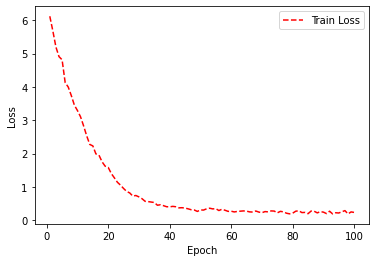

In [23]:
epoch_count = range(1, len(loss_history) + 1) 

# Visualize loss history
plt.plot(epoch_count, loss_history, 'r--')
plt.legend(['Train Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

### **More powerful cell!**

In the previous part, we implemented a simple Elman recurrent network. We can easily extend it to an **LSTM** by modifying our code slightly. Since we already learned how to implement the recurrent cell itself, in this part, we will simply use the existing pytorch `nn.LSTM` implementation. One major difference between these two networks is their **hidden state**. Unlike an Elman RNN which has only a single state, the hidden state of an LSTM is made up of two parts.
You can take a look at the online documentation of [`nn.LSTM`](https://pytorch.org/docs/stable/nn.html?highlight=lstm#torch.nn.LSTM) as well as [`nn.LSTMCell`](https://pytorch.org/docs/stable/nn.html?highlight=lstmcell#torch.nn.LSTMCell)

<img src="https://www.knime.com/sites/default/files/fig_2_2.png" alt="img" width="512px"/>

Please fill in the forward function of the LSTM network.

In [24]:
class LSTMLanguageModel(nn.Module):
    def __init__(self, n_tokens, hidden_sz):
        super(LSTMLanguageModel, self).__init__()
        self.hidden_size = hidden_sz
        
        self.embedding = nn.Embedding(n_tokens, hidden_sz)
        self.rnn = nn.LSTM(hidden_sz, hidden_sz, batch_first=True)
        self.decoder = nn.Linear(hidden_sz, n_tokens)
        
    def forward(self, x, prev_state):
        """
        :return: logits, state; where logits is output of the decoder,
                 and state is the final rnn state.
        """
        ############### for student ################
        embedding = self.embedding(x)
        out,state = self.rnn(embedding,prev_state)
        logits = self.decoder(out)
        return logits, state
        ############################################
    
    def zero_state(self, batch_size, dev):
        """
        look up the dimensions of the nn.LSTM state (which is a tuple!)
        return a zero-initialized state
        put on the correct device (dev)
        """
        return (torch.zeros(1, batch_size, self.hidden_size).to(dev),
                torch.zeros(1, batch_size, self.hidden_size).to(dev))
    

In [25]:
## evaluation
## DON'T CHANGE THIS CELL IN ANY WAY

# Let's test the LSTM model
arr = torch.randint(n_token, [64, 32], dtype=torch.long).to(device)
model = LSTMLanguageModel(n_token, 256).to(device)
state = model.zero_state(64, device)
out, state = model(arr, state)

assert type(out) != type(None), 'Did you return output?'
assert type(state) != type(None), 'How about state?'
assert out.shape == torch.Size([64, 32, n_token]), out.shape
assert isinstance(state, tuple) 
print("LSTM is complete! Perfect!")

LSTM is complete! Perfect!


### **Evaluation method**

So far, we have only evaluated the performance of our neural networks throughout the training loop, only calculating the loss for a single mini-batch at a time. Now, we will create an evaluation method to evaluate the performance of our network across multiple batches. 

Complete the __evaluate()__ method below so that it returns the overall (mean) cross-entropy loss. 

In [26]:
def evaluate(device, net, n_token, batch_size, seq_size, x_test, y_test):
    
    net.eval()
    
    total_loss = 0.
    
    # intialize state
    state_h, state_c = net.zero_state(batch_size, device)
    state_h = state_h.to(device)
    state_c = state_c.to(device)
    print(state_h.shape)
    print(state_c.shape)
    
    # batchify data
    batches = get_batches(x_test, y_test, batch_size, seq_size)
    
    # 1) loop through the batches
    ##   convert data to tensor and put it on the device
    ##   calculate forward path
    ##   use 'criterion' (as defined earlier in the training loop) to calculate the loss for each mini-batch (reshape might be needed)
    ##   add mini-batch loss to total_loss
    ##   detach() states
    # 2) return average loss
    ############### for student ################
    iteration = 0
    for x, y in batches:
        iteration += 1
        x = torch.tensor(x).to(device)
        y = torch.tensor(y).to(device)
        out,(hn,cn) = net(x,(state_h,state_c))
        # print(out.shape)
        loss = criterion(torch.transpose(out,1,2), y)
        # print(loss)
        total_loss += loss
    average_loss = (total_loss/iteration).cpu().data
    # print(average_loss)
    return average_loss

    
id_to_token, token_to_id, n_token, inp_text, out_text = get_data_lm(dummy_text)
net = LSTMLanguageModel(n_token, 256).to(device)    
dummy_loss = evaluate(device, net, n_token, 10, 64, inp_text, out_text)
        









    ############################################

torch.Size([1, 10, 256])
torch.Size([1, 10, 256])


In [27]:
## evaluation
## DON'T CHANGE THIS CELL IN ANY WAY

id_to_token, token_to_id, n_token, inp_text, out_text = get_data_lm(dummy_text)
net = LSTMLanguageModel(n_token, 256).to(device)
dummy_loss = evaluate(device, net, n_token, 10, 64, inp_text, out_text)

assert np.exp(dummy_loss) < 1e4, 'your dummy loss is too large!'

print("It looks alright.")

torch.Size([1, 10, 256])
torch.Size([1, 10, 256])
It looks alright.


### Train the LSTM

Let's train the LSTM on a small amount of dummy text:

In [28]:
id_to_token, token_to_id, n_token, inp_text, out_text = get_data_lm(dummy_text)
X_train, X_test, y_train, y_test = train_test_split(inp_text, out_text, test_size=0.25, random_state=SEED)

Modify the training loop you defined for the elman RNN, and use it to train the LSTM model:

In [29]:
net = LSTMLanguageModel(n_token, hidden_size)
net = net.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters())

iteration = 0
total_epochs = 100

train_loss = 0
train_history = []
valid_history = []


for e in range(total_epochs):
    
    batches = get_batches(X_train, y_train, batch_size, seq_size)
    
    
    # 1) call zero_state
    # 2) put on the correct device
    # 3) loop through the data
    #     (See RNNLanguage model for the logic)
    
    ############### for student ################
    state_h,state_c = net.zero_state(batch_size,device)
    state_h = state_h.to(device)
    state_c = state_c.to(device)
    
    for x, y in batches:

        iteration += 1

        x = torch.tensor(x).to(device)
        y = torch.tensor(y).to(device)
        optimizer.zero_grad()
        logits, (hn,cn) = net(x, (state_h,state_c))
        loss = criterion(torch.transpose(logits,1,2), y)  
        loss.backward()           
        optimizer.step() 
    ############################################
        
        if iteration % 50 == 0:
            train_loss = train_loss / 50.0
            val_loss = evaluate(device, net, n_token, 10, seq_size, X_test, y_test)
            
            train_history.append(train_loss)
            valid_history.append(val_loss)
            
            print('epoch: {}/{} iteration: {} train-Loss: {} val-loss: {}'.format(e, total_epochs, iteration, train_loss, val_loss))
            train_loss = 0

torch.Size([1, 10, 256])
torch.Size([1, 10, 256])
epoch: 1/100 iteration: 50 train-Loss: 0.0 val-loss: 6.407227993011475
torch.Size([1, 10, 256])
torch.Size([1, 10, 256])
epoch: 3/100 iteration: 100 train-Loss: 0.0 val-loss: 6.181799411773682
torch.Size([1, 10, 256])
torch.Size([1, 10, 256])
epoch: 5/100 iteration: 150 train-Loss: 0.0 val-loss: 6.017387866973877
torch.Size([1, 10, 256])
torch.Size([1, 10, 256])
epoch: 7/100 iteration: 200 train-Loss: 0.0 val-loss: 5.939611911773682
torch.Size([1, 10, 256])
torch.Size([1, 10, 256])
epoch: 9/100 iteration: 250 train-Loss: 0.0 val-loss: 5.910603046417236
torch.Size([1, 10, 256])
torch.Size([1, 10, 256])
epoch: 11/100 iteration: 300 train-Loss: 0.0 val-loss: 5.943719387054443
torch.Size([1, 10, 256])
torch.Size([1, 10, 256])
epoch: 12/100 iteration: 350 train-Loss: 0.0 val-loss: 5.957814693450928
torch.Size([1, 10, 256])
torch.Size([1, 10, 256])
epoch: 14/100 iteration: 400 train-Loss: 0.0 val-loss: 5.9651055335998535
torch.Size([1, 10, 25

In [30]:
## evaluation
## DON'T CHANGE THIS CELL IN ANY WAY

dummy_loss = evaluate(device, net, n_token, 10, 64, X_test, y_test)

assert np.exp(dummy_loss) < 1e4, 'your dummy loss is too large!'

print("Good job! We're almost done..")

torch.Size([1, 10, 256])
torch.Size([1, 10, 256])
Good job! We're almost done..


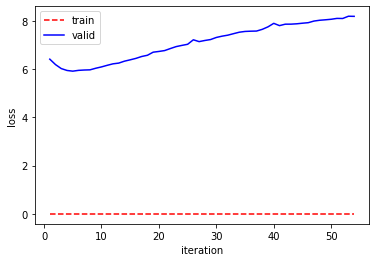

In [31]:
epoch_count = range(1, len(train_history) + 1) 

# Visualize loss history
plt.plot(epoch_count, train_history, 'r--')
plt.plot(epoch_count, valid_history, 'b-')
plt.legend(['train', 'valid'])
plt.xlabel('iteration')
plt.ylabel('loss')
plt.show()

What we see on the plot above is known as __overfitting__: the training loss becomes really small towards the end of training, but the validation error of the model is high. This is due to the model learning “too much” from the training dataset, so that it does not generalize well to unseen data. You can probably guess why this happened? We are still training the model on a small subsample of the data (`dummy_text`)! If you train the model on the whole dataset, you will definitely get better validation scores. You can try this out if you want to, but be aware that training will likely take much longer. 

### Question 6

Give at least 6 ideas on how you could make your neural language model better (short, bullet-style answers). (You can find inspiration online, for example here: https://arxiv.org/pdf/1708.02182.pdf) 

**<font color=blue><<< INSERT ANSWER HERE >>></font>**

1.   collect more amount of data
2.   process data by using activiation functions
3.   feature selection
4.   data visualization to weed out abnormal values
5.   parameter tuning: weight initialization, learining rate, batch_size, epoch, activation function selection, numbers of hidden layers, regularization, 
6.   algrithm optimization
7.   normalization




**If you would have a lot more time (not within the scope of this lab!)**: you've learned the building blocks of neural language models, you can now build the ultimate monster:
* Weight tying: Two weight matrices have been used for input or output respectively (https://arxiv.org/abs/1608.05859)
* Make it character-level or make use of sub-word units like [bpe](https://en.wikipedia.org/wiki/Byte_pair_encoding);
* Use both character-level and word-level features to train a word-level language model
* ...

### Question 7

Please give us a rough estimation of the hours you invested to complete this session. This will not affect your grade ;) However, it might help us with the design of our future lab sessions. 
 
**<font color=blue><<< Around 70 hours >>></font>**

## Acknowledgment
If you received help or feedback from fellow students, please acknowledge that here. We count on your academic honesty:

**<font color=blue><<< INSERT ANSWER HERE >>></font>**
